Base treino: 700 | Base teste: 300
--------------------------------------------------


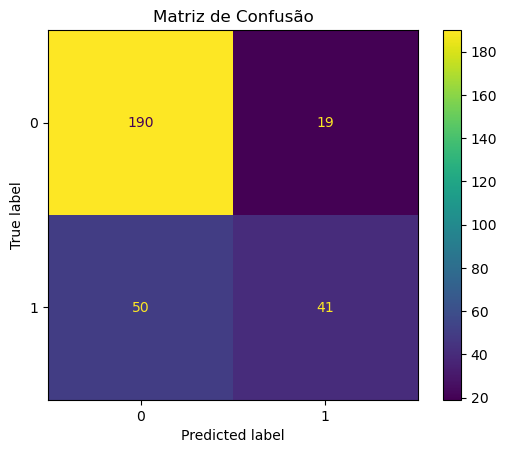

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       209
           1       0.68      0.45      0.54        91

    accuracy                           0.77       300
   macro avg       0.74      0.68      0.69       300
weighted avg       0.76      0.77      0.75       300



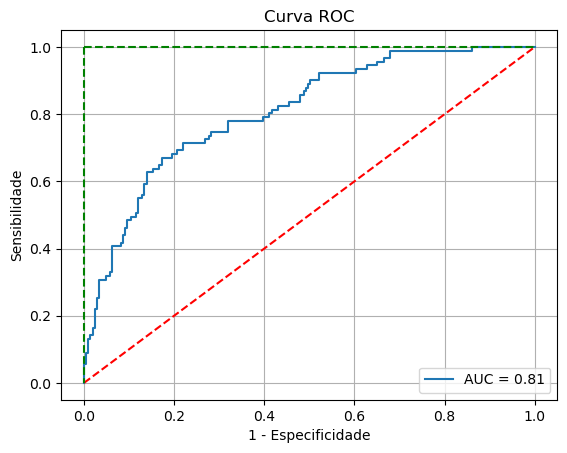

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# ==============================
# Função de pré-processamento
# ==============================

def preprocessar_dados(df):
    # Mapas de transformação
    mapeamentos = {
        'conta_corrente': {'no checking account':4, '>= 200 DM / salary assignments for at least 1 year':3, '0 <= ... < 200 DM':2, '< 0 DM':1},
        'historico_credito': {'no credits taken/ all credits paid back duly':1, 'all credits at this bank paid back duly':2, 'existing credits paid back duly till now':3, 'delay in paying off in the past':4, 'critical account/ other credits existing (not at this bank)':5},
        'proposito_emprestimo': {'car (new)':1, 'car (used)':2, 'furniture/equipment':3, 'radio/television':4, 'domestic appliances':5, 'repairs':6, 'education':7, '(vacation - does not exist?)':8, 'retraining':9, 'business':10, 'others':11},
        'reserva_cc': {'unknown/ no savings account' : 1, '.. >= 1000 DM ' : 2, '500 <= ... < 1000 DM ' : 3, '100 <= ... < 500 DM' : 4, '... < 100 DM' : 5},
        'tempo_emprego_atual': { '.. >= 7 years' : 1, '4 <= ... < 7 years' : 2, '1 <= ... < 4 years' : 3, '... < 1 year ' : 4, 'unemployed' : 5},
        'sexo_est_civil': {'male : divorced/separated':1, 'female : divorced/separated/married':2, 'male : single':3, 'male : married/widowed':4, 'female : single':5},
        'outros_fiadores': { 'none':1, 'co-applicant':2, 'guarantor':3},
        'propriedade': {'real estate':1, 'if not A121 : building society savings agreement/ life insurance':2,'if not A121/A122 : car or other, not in attribute 6':3, 'unknown / no property':4 },
        'outros_planos_financiamento': {'bank':1, 'stores':2, 'none':3},
        'tipo_residencia': {'rent':1, 'own':2, 'for free':3},
        'status_emprego': {'unemployed/ unskilled - non-resident':1, 'unskilled - resident':2, 'skilled employee / official':3, 'management/ self-employed/ highly qualified employee/ officer':4},
        'telefone': {'yes, registered under the customers name ':1, 'none':0},
        'trabalhador_estrangeiro': {'yes' : 1, 'no' : 0}
    }

    for coluna, mapa in mapeamentos.items():
        df[coluna] = df[coluna].map(mapa)

    # Extrai sexo e estado civil
    df['sexo'] = df['sexo_est_civil'].map({2:1, 5:1, 1:0, 3:0, 4:0})
    df['estado_civil'] = df['sexo_est_civil'].map({3:1, 5:1, 1:0, 2:0, 4:0})

    # Faixas
    df['faixa_idade'] = pd.cut(df['idade'], bins=[18, 30, 40, 50, 60, 70, 80], labels=[1, 2, 3, 4, 5, 6])
    df['faixa_prazo_emprestimo'] = pd.cut(df['prazo_emprestimo_meses'], bins=[1, 12, 24, 36, 48, 60, 72], labels=[1, 2, 3, 4, 5, 6])
    df['faixa_valor_emprestimo'] = pd.cut(df['valor_emprestimo'], bins=list(range(0, 21000, 1000)), labels=list(range(1, 21)))

    # Remove colunas
    df = df.drop(columns=['sexo_est_civil', 'sexo', 'idade', 'prazo_emprestimo_meses', 'valor_emprestimo'])

    return df

# ==============================
# Função que roda o modelo
# ==============================

def roda_modelo(df, classificador):

    x = df.drop(columns='default')
    y = df['default'] # coluna target 0:negar credito 1:conceder credito
    
    treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.3, random_state=42)

    modelo = classificador
    modelo.fit(treino_x, treino_y)

    print(f"Base treino: {len(treino_x)} | Base teste: {len(teste_x)}\n{'-'*50}")
    
    # Previsões
    previsoes = modelo.predict(teste_x)
    probas = modelo.predict_proba(teste_x)[:,1]

    # Matriz de confusão
    ConfusionMatrixDisplay.from_estimator(modelo, teste_x, teste_y)
    plt.title("Matriz de Confusão")
    plt.show()

    # Relatório
    print(classification_report(teste_y, previsoes))

    # Curva ROC
    fpr, tpr, _ = roc_curve(teste_y, probas)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(teste_y, probas):.2f}")
    plt.plot([0, 1], linestyle = '--', c = 'red')
    plt.plot([0, 0], [1, 0], linestyle = '--', c = 'green')
    plt.plot([1, 1], linestyle = '--', c = 'green')
    plt.xlabel("1 - Especificidade")
    plt.ylabel("Sensibilidade")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid()
    plt.show()

    return modelo

# ==============================
# Execução
# ==============================

# Carrega base
df_original = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/credit_scoring/main/base_dados_traduzida.csv')

# Pré-processa
df_limpo = preprocessar_dados(df_original)

# Treina o modelo
modelo_final = roda_modelo(df_limpo, LogisticRegression(max_iter=1000))

In [53]:
# 1️⃣ Seleciona a linha original (ex: cliente da linha 0)
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/credit_scoring/main/base_dados_traduzida.csv')
cliente_real = df.iloc[[9]]  # ATENÇÃO: os colchetes duplos mantêm o formato de DataFrame

# 2️⃣ Pré-processa exatamente como na base de treino
cliente_processado = preprocessar_dados(cliente_real)

# 3️⃣ Faz a previsão (excluindo a coluna 'default')
previsao = modelo_final.predict(cliente_processado.drop(columns='default'))

# 4️⃣ Resultado
print("🔍 Resultado:", "Conceder crédito" if previsao[0] == 1 else "Negar crédito")

🔍 Resultado: Conceder crédito
